In [1]:
"""Example for plotting gradient data"""
import os.path as op
from glob import glob
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from utils import plot_gradient

In [2]:
cmap = nilearn_cmaps['cold_hot']
data_dir = "../data"

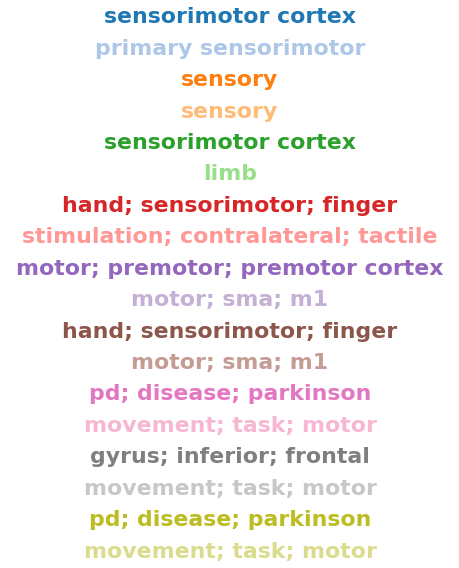

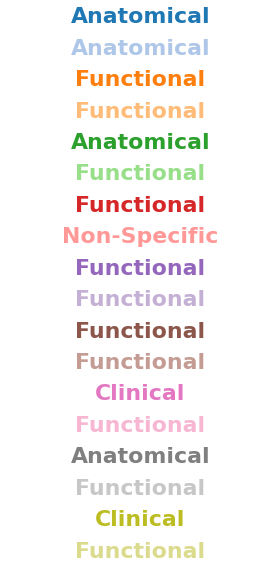

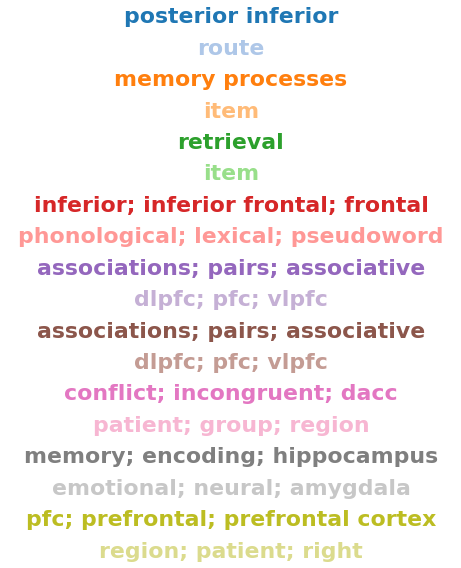

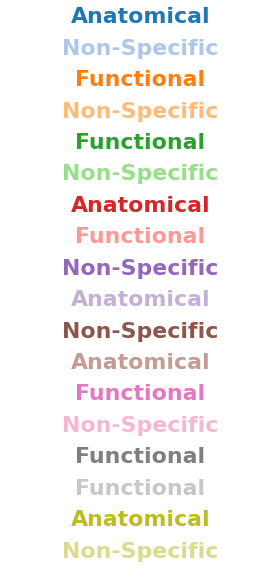

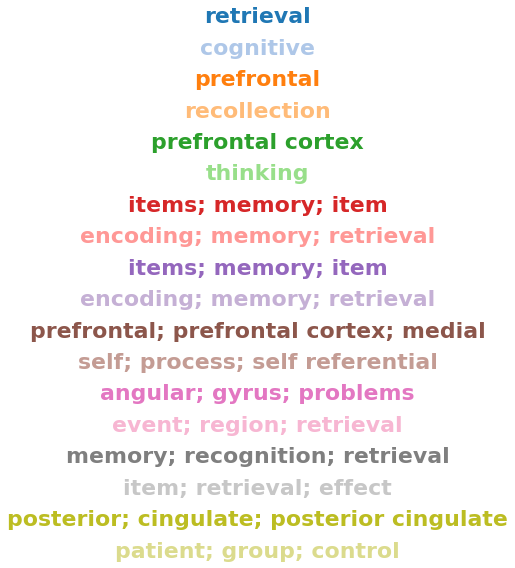

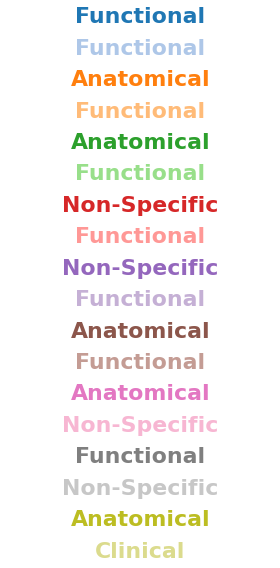

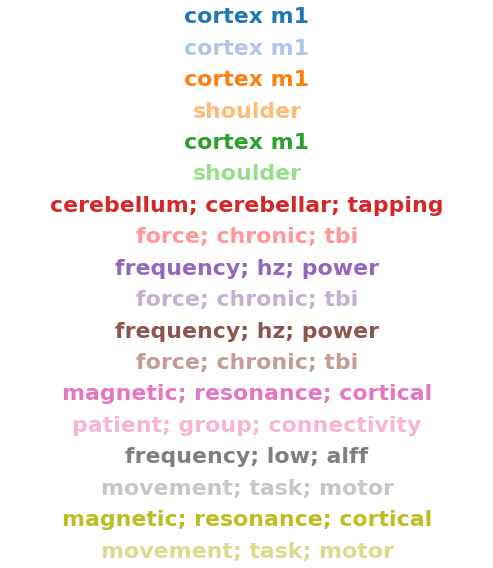

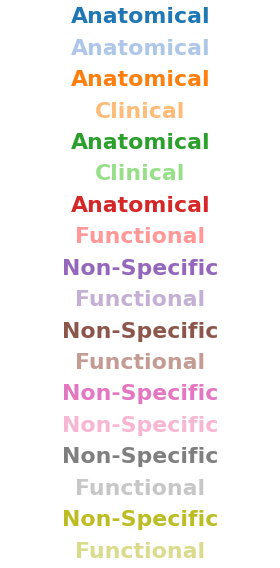

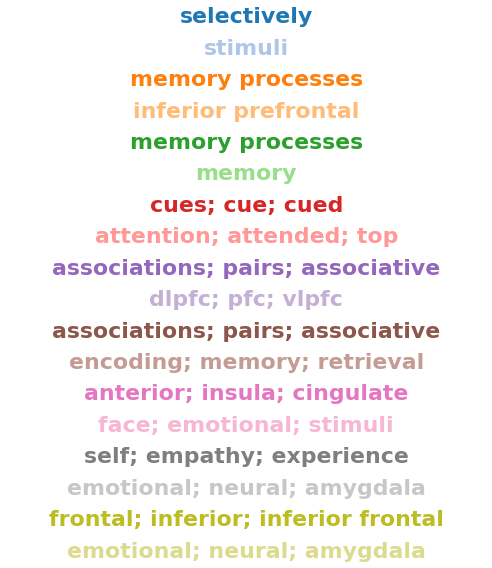

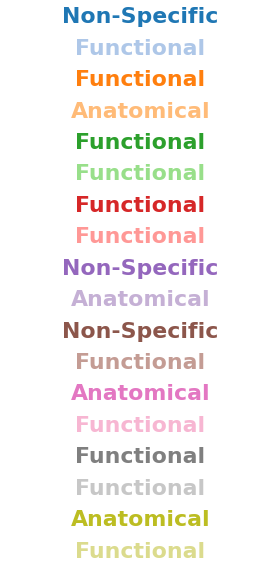

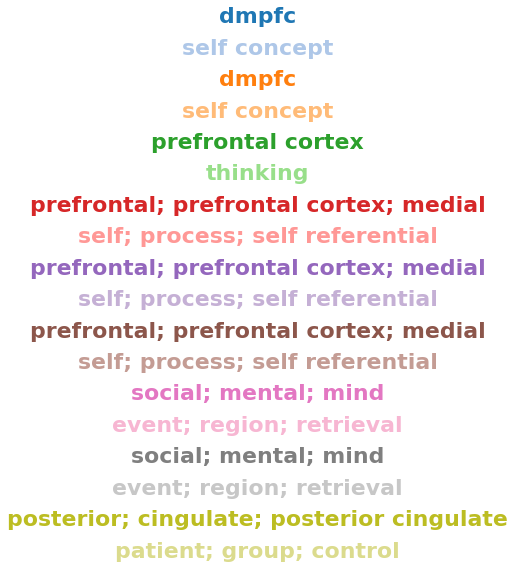

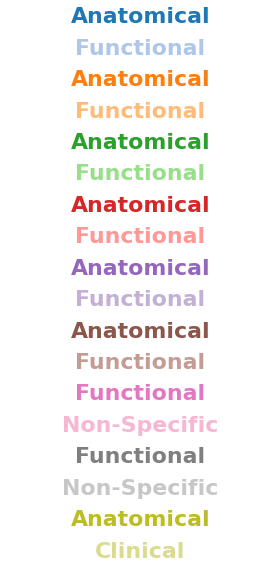

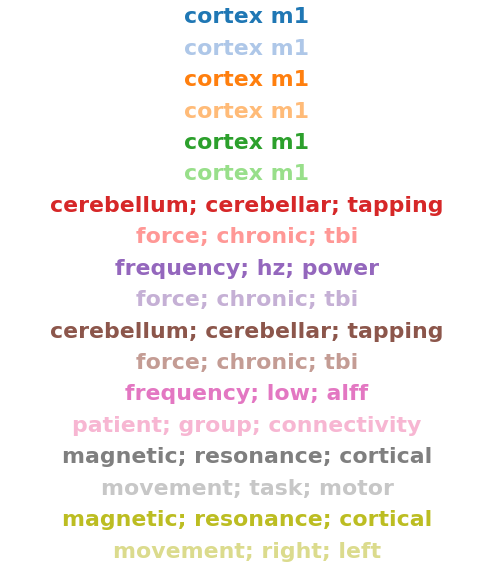

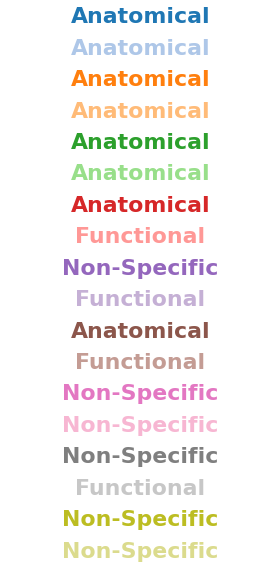

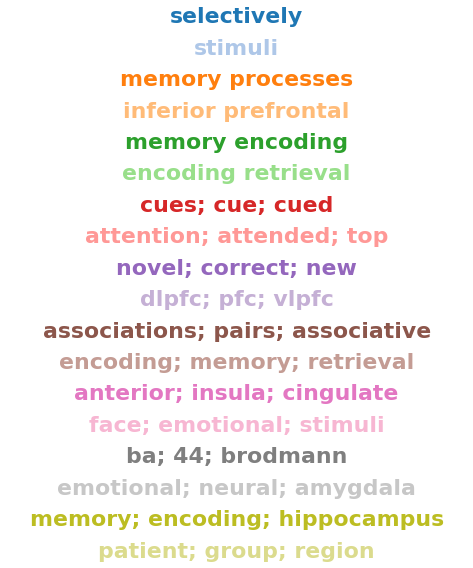

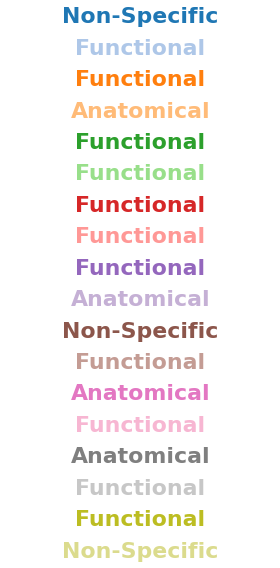

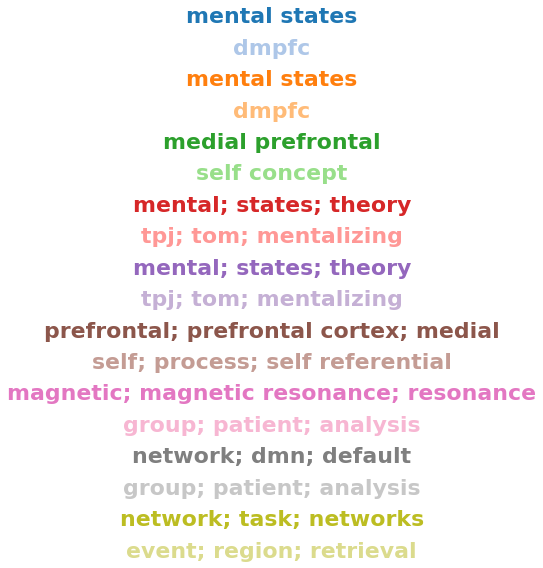

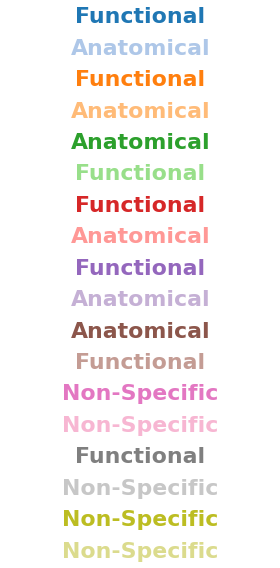

In [3]:
methods = ["Percentile", "KMeans", "KDE"]
dset_names = ["neurosynth", "neuroquery"]
models = ["term", "lda", "gclda"]

colors = plt.get_cmap("tab20")
segmentations = [3, 17, 32]
seg_sols = [[1, 2, 3], [1, 9, 17], [1, 16, 32]]
data_df = pd.read_csv("../results/performance/performance.tsv", delimiter="\t")
map_out_path = "../figures/Fig/decoding"
features_lst = []
prefix_lst = []
for seg_i, segmentation in enumerate(segmentations):
    for seg_sol in seg_sols[seg_i]:
        sub_features_lst = []
        sub_class_lst = []
        for model_i, model in enumerate(models):
            for iter_i, (method, dset_name) in enumerate(itertools.product(methods, dset_names)):
            
                method_name = f"{model}_{dset_name}_{method}"
                temp_df = data_df[
                    (data_df["method"] == method_name) & 
                    (data_df["segment_solution"] == segmentation) &
                    (data_df["segment"] == seg_sol)
                ]
                corr_idx = temp_df["corr_idx"].values[0]
                corr_idx_str = f"{corr_idx:04d}" if model == "term" else f"{corr_idx:03d}"

                threshold, cmap = (0.00001, "afmhot") if model == "gclda" else (2, cmap)

                map_path = f"../results/decoding/{model}_{dset_name}_fslr"
                map_lh_fnames = sorted(glob(op.join(map_path, f"*_desc-*{corr_idx_str}*_hemi-L_feature.func.gii")))
                map_rh_fnames = sorted(glob(op.join(map_path, f"*_desc-*{corr_idx_str}*_hemi-R_feature.func.gii")))
                map_fnames = zip(map_lh_fnames, map_rh_fnames)

                prefix = f"{segmentation:02d}-{seg_sol:02d}-{model_i}-{iter_i}-{method}"
                """
                plot_gradient(
                    data_dir, 
                    map_fnames, 
                    threshold_=threshold, 
                    cmap=cmap, 
                    views='lateral', 
                    out_dir=map_out_path, 
                    prefix=prefix,
                )
                """

                prefix_lst.append(prefix)
                feature = temp_df["features"].values[0]
                
                if model != "term":
                    feature = "; ".join(feature.split("_")[1:])

                features_lst.append(feature)
                sub_features_lst.append(feature)
                sub_class_lst.append(temp_df["classification"].values[0])
        
        # Plot features
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 8)

        n_methods = len(sub_features_lst)
        y_coords = np.linspace(1, 0, n_methods)

        for y_coord, color, text in zip(y_coords, colors.colors[:n_methods], sub_features_lst):
            text_kwargs = dict(ha="center", va="center", weight='bold', fontsize=22, color=color)
            text = ax.text(0.5, y_coord, text, **text_kwargs)

        ax.axis('off')
        fig.tight_layout()
        plt.savefig(op.join("./Fig", "performance", f"features-{segmentation:02d}-{seg_sol:02d}.eps"), bbox_inches="tight")
        plt.show()

        # Plot classification
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(4, 8)

        n_methods = len(sub_class_lst)
        y_coords = np.linspace(1, 0, n_methods)

        for y_coord, color, text in zip(y_coords, colors.colors[:n_methods], sub_class_lst):
            text_kwargs = dict(ha="center", va="center", weight='bold', fontsize=22, color=color)
            text = ax.text(0.5, y_coord, text, **text_kwargs)

        ax.axis('off')
        fig.tight_layout()
        plt.savefig(op.join("./Fig", "performance", f"classification-{segmentation:02d}-{seg_sol:02d}.eps"), bbox_inches="tight")
        plt.show()
